# Larvae classification

## 1. Definitions

In [ ]:
from pathlib import Path

import torch
from dataset import ImageDataLoadBuilder, visualize_larvae_sample
from metrics import accuracy_fn, cohen_kappa_fn
from models import FlexCNNClassifier
from torch import nn, optim
from torchsummary import summary
from torchvision import transforms
from training import Trainer

In [2]:
device = torch.device(0) if torch.cuda.is_available() else torch.device("cpu")

In [3]:
width = 224
height = 224
nchannels = 3
input_size = (height, width)
input_shape = (nchannels, height, width)
num_classes = 2
imagenet_mean, imagenet_std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

## 2. Data ETL

In [4]:
# Regular preprocessing transformation
preparation = transforms.Compose(
    [
        transforms.Resize(
            input_size,
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]
)

# Data augmentation transformation
augmentation = transforms.Compose(
    [
        transforms.Resize(
            (300, 300),
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.RandomAffine(
            degrees=10,
            translate=(0.05, 0.10),
            scale=(0.9, 1.1),
            shear=(-2, 2),
            interpolation=transforms.InterpolationMode.BILINEAR,
            fill=0,
        ),
        transforms.CenterCrop(250),
        preparation,
    ]
)

In [5]:
builder = ImageDataLoadBuilder(
    data_dir=Path("../images/larvae"),
    train_transform=augmentation,
    valid_transform=preparation,
    test_transform=preparation,
)
train_loader, valid_loader, test_loader = builder.get_tvt_splited_dataloaders()

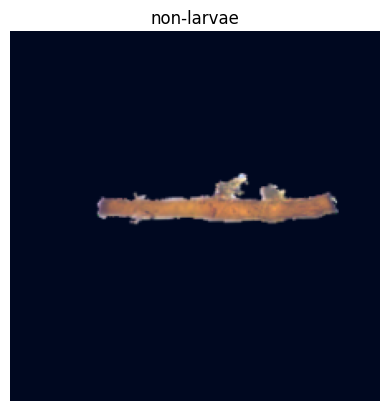

In [ ]:
visualize_larvae_sample(train_loader.dataset)

In [7]:
len(train_loader.dataset), len(valid_loader.dataset), len(test_loader.dataset)

(799, 319, 480)

## 3. Training

### 3.1. Criterion

Since larvae data is unbalanced, we will use cross entropy with weights.

In [8]:
from torch import Tensor

N0 = 247
N1 = 1351
weights = Tensor([1.0, N0 / N1])
criterion = nn.CrossEntropyLoss(weight=weights)

# criterion = nn.CrossEntropyLoss()

### 3.2. CNN0

In [9]:
cnn_0 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[32],
    conv_channels=[8,16],
    use_dropout=True,
    use_batchnorm=True,
)
summary(cnn_0, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]             216
       BatchNorm2d-2          [-1, 8, 224, 224]              16
              ReLU-3          [-1, 8, 224, 224]               0
         MaxPool2d-4          [-1, 8, 112, 112]               0
            Conv2d-5         [-1, 16, 112, 112]           1,152
       BatchNorm2d-6         [-1, 16, 112, 112]              32
              ReLU-7         [-1, 16, 112, 112]               0
         MaxPool2d-8           [-1, 16, 56, 56]               0
            Linear-9                   [-1, 32]       1,605,664
             ReLU-10                   [-1, 32]               0
          Dropout-11                   [-1, 32]               0
           Linear-12                    [-1, 2]              66
Total params: 1,607,146
Trainable params: 1,607,146
Non-trainable params: 0
---------------------------

In [10]:
optimizer_cnn_0 = optim.Adam(cnn_0.parameters(), lr=1e-4)
scheduler_cnn_0 = optim.lr_scheduler.StepLR(optimizer_cnn_0, step_size=25, gamma=0.1)
ckpt_cnn_0 = "weights/cnn_0.pt"
trainer_cnn_0 = Trainer(
    model=cnn_0,
    optimizer=optimizer_cnn_0,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_0,
    checkpoint_path=ckpt_cnn_0,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn],
)

In [11]:
trainer_cnn_0.fit(train_loader, valid_loader, num_epochs=100)

📘 Epoch 1 | Train Loss: 0.6619 | Val Loss: 0.6365 | Val cohen_kappa_fn: 0.1097 | Val accuracy_fn: 0.4922
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6174 | Val Loss: 0.5967 | Val cohen_kappa_fn: 0.1143 | Val accuracy_fn: 0.7586
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.5856 | Val Loss: 0.5741 | Val cohen_kappa_fn: 0.2169 | Val accuracy_fn: 0.6708
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.5895 | Val Loss: 0.5627 | Val cohen_kappa_fn: 0.1830 | Val accuracy_fn: 0.8056
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.5303 | Val Loss: 0.5624 | Val cohen_kappa_fn: 0.2021 | Val accuracy_fn: 0.7273
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.5340 | Val Loss: 0.5433 | Val cohen_kappa_fn: 0.2725 | Val accuracy_fn: 0.7429
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.5298 | Val Loss: 0.5546 | Val cohen_kappa_fn: 0.2644 | Val accuracy_fn: 0.7367
  ❄️ Performance droped, model won't be saved!


📘 Epoch 8 | Train Loss: 0.5027 | Val Loss: 0.6103 | Val cohen_kappa_fn: 0.1999 | Val accuracy_fn: 0.8245
  ❄️ Performance droped, model won't be saved!


📘 Epoch 9 | Train Loss: 0.4963 | Val Loss: 0.5686 | Val cohen_kappa_fn: 0.2223 | Val accuracy_fn: 0.6677
  ❄️ Performance droped, model won't be saved!


📘 Epoch 10 | Train Loss: 0.4852 | Val Loss: 0.5473 | Val cohen_kappa_fn: 0.1816 | Val accuracy_fn: 0.6144
  ❄️ Performance droped, model won't be saved!


📘 Epoch 11 | Train Loss: 0.4831 | Val Loss: 0.5209 | Val cohen_kappa_fn: 0.3005 | Val accuracy_fn: 0.7900
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.4939 | Val Loss: 0.5183 | Val cohen_kappa_fn: 0.3005 | Val accuracy_fn: 0.7900
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.4713 | Val Loss: 0.5223 | Val cohen_kappa_fn: 0.2298 | Val accuracy_fn: 0.6834
  ❄️ Performance droped, model won't be saved!


📘 Epoch 14 | Train Loss: 0.4836 | Val Loss: 0.5380 | Val cohen_kappa_fn: 0.2256 | Val accuracy_fn: 0.7210
  ❄️ Performance droped, model won't be saved!


📘 Epoch 15 | Train Loss: 0.4780 | Val Loss: 0.5121 | Val cohen_kappa_fn: 0.3139 | Val accuracy_fn: 0.8558
  🔥 New best model saved!


📘 Epoch 16 | Train Loss: 0.5052 | Val Loss: 0.4921 | Val cohen_kappa_fn: 0.3264 | Val accuracy_fn: 0.7931
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.4689 | Val Loss: 0.4828 | Val cohen_kappa_fn: 0.3968 | Val accuracy_fn: 0.8621
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.4760 | Val Loss: 0.4578 | Val cohen_kappa_fn: 0.3522 | Val accuracy_fn: 0.8025
  🔥 New best model saved!


📘 Epoch 19 | Train Loss: 0.4445 | Val Loss: 0.4573 | Val cohen_kappa_fn: 0.3119 | Val accuracy_fn: 0.7712
  🔥 New best model saved!


📘 Epoch 20 | Train Loss: 0.4410 | Val Loss: 0.4685 | Val cohen_kappa_fn: 0.3213 | Val accuracy_fn: 0.8025
  ❄️ Performance droped, model won't be saved!


📘 Epoch 21 | Train Loss: 0.4500 | Val Loss: 0.4696 | Val cohen_kappa_fn: 0.3262 | Val accuracy_fn: 0.7806
  ❄️ Performance droped, model won't be saved!


📘 Epoch 22 | Train Loss: 0.4344 | Val Loss: 0.4584 | Val cohen_kappa_fn: 0.3410 | Val accuracy_fn: 0.7900
  ❄️ Performance droped, model won't be saved!


📘 Epoch 23 | Train Loss: 0.4507 | Val Loss: 0.4482 | Val cohen_kappa_fn: 0.3496 | Val accuracy_fn: 0.7837
  🔥 New best model saved!


📘 Epoch 24 | Train Loss: 0.4105 | Val Loss: 0.4496 | Val cohen_kappa_fn: 0.4202 | Val accuracy_fn: 0.8621
  ❄️ Performance droped, model won't be saved!


📘 Epoch 25 | Train Loss: 0.4504 | Val Loss: 0.4778 | Val cohen_kappa_fn: 0.4242 | Val accuracy_fn: 0.8683
  ❄️ Performance droped, model won't be saved!


📘 Epoch 26 | Train Loss: 0.4122 | Val Loss: 0.4591 | Val cohen_kappa_fn: 0.3911 | Val accuracy_fn: 0.8495
  ❄️ Performance droped, model won't be saved!


📘 Epoch 27 | Train Loss: 0.4206 | Val Loss: 0.4491 | Val cohen_kappa_fn: 0.3494 | Val accuracy_fn: 0.8182
  ❄️ Performance droped, model won't be saved!


📘 Epoch 28 | Train Loss: 0.4177 | Val Loss: 0.4477 | Val cohen_kappa_fn: 0.3436 | Val accuracy_fn: 0.8150
  🔥 New best model saved!


📘 Epoch 29 | Train Loss: 0.4258 | Val Loss: 0.4433 | Val cohen_kappa_fn: 0.3436 | Val accuracy_fn: 0.8150
  🔥 New best model saved!


📘 Epoch 30 | Train Loss: 0.4134 | Val Loss: 0.4384 | Val cohen_kappa_fn: 0.3436 | Val accuracy_fn: 0.8150
  🔥 New best model saved!


📘 Epoch 31 | Train Loss: 0.4345 | Val Loss: 0.4405 | Val cohen_kappa_fn: 0.3801 | Val accuracy_fn: 0.8182
  ❄️ Performance droped, model won't be saved!


📘 Epoch 32 | Train Loss: 0.4106 | Val Loss: 0.4357 | Val cohen_kappa_fn: 0.3801 | Val accuracy_fn: 0.8182
  🔥 New best model saved!


📘 Epoch 33 | Train Loss: 0.4018 | Val Loss: 0.4436 | Val cohen_kappa_fn: 0.3860 | Val accuracy_fn: 0.8213
  ❄️ Performance droped, model won't be saved!


📘 Epoch 34 | Train Loss: 0.4073 | Val Loss: 0.4381 | Val cohen_kappa_fn: 0.3860 | Val accuracy_fn: 0.8213
  ❄️ Performance droped, model won't be saved!


📘 Epoch 35 | Train Loss: 0.4067 | Val Loss: 0.4427 | Val cohen_kappa_fn: 0.3702 | Val accuracy_fn: 0.8182
  ❄️ Performance droped, model won't be saved!


📘 Epoch 36 | Train Loss: 0.4096 | Val Loss: 0.4429 | Val cohen_kappa_fn: 0.3600 | Val accuracy_fn: 0.8182
  ❄️ Performance droped, model won't be saved!


📘 Epoch 37 | Train Loss: 0.4181 | Val Loss: 0.4331 | Val cohen_kappa_fn: 0.3702 | Val accuracy_fn: 0.8182
  🔥 New best model saved!


📘 Epoch 38 | Train Loss: 0.4297 | Val Loss: 0.4314 | Val cohen_kappa_fn: 0.3485 | Val accuracy_fn: 0.8119
  🔥 New best model saved!


📘 Epoch 39 | Train Loss: 0.4247 | Val Loss: 0.4279 | Val cohen_kappa_fn: 0.3385 | Val accuracy_fn: 0.8182
  🔥 New best model saved!


📘 Epoch 40 | Train Loss: 0.4241 | Val Loss: 0.4362 | Val cohen_kappa_fn: 0.3485 | Val accuracy_fn: 0.8119
  ❄️ Performance droped, model won't be saved!


📘 Epoch 41 | Train Loss: 0.4001 | Val Loss: 0.4397 | Val cohen_kappa_fn: 0.3444 | Val accuracy_fn: 0.8213
  ❄️ Performance droped, model won't be saved!


📘 Epoch 42 | Train Loss: 0.4222 | Val Loss: 0.4355 | Val cohen_kappa_fn: 0.3485 | Val accuracy_fn: 0.8119
  ❄️ Performance droped, model won't be saved!


📘 Epoch 43 | Train Loss: 0.4123 | Val Loss: 0.4277 | Val cohen_kappa_fn: 0.3613 | Val accuracy_fn: 0.8245
  🔥 New best model saved!


📘 Epoch 44 | Train Loss: 0.4087 | Val Loss: 0.4379 | Val cohen_kappa_fn: 0.3436 | Val accuracy_fn: 0.8150
  ❄️ Performance droped, model won't be saved!


📘 Epoch 45 | Train Loss: 0.4023 | Val Loss: 0.4341 | Val cohen_kappa_fn: 0.3613 | Val accuracy_fn: 0.8245
  ❄️ Performance droped, model won't be saved!


📘 Epoch 46 | Train Loss: 0.4475 | Val Loss: 0.4403 | Val cohen_kappa_fn: 0.3766 | Val accuracy_fn: 0.8056
  ❄️ Performance droped, model won't be saved!


📘 Epoch 47 | Train Loss: 0.4131 | Val Loss: 0.4344 | Val cohen_kappa_fn: 0.3728 | Val accuracy_fn: 0.8088
  ❄️ Performance droped, model won't be saved!


📘 Epoch 48 | Train Loss: 0.4304 | Val Loss: 0.4379 | Val cohen_kappa_fn: 0.3820 | Val accuracy_fn: 0.8245
  ❄️ Performance droped, model won't be saved!
⏹️ Early stopping triggered.


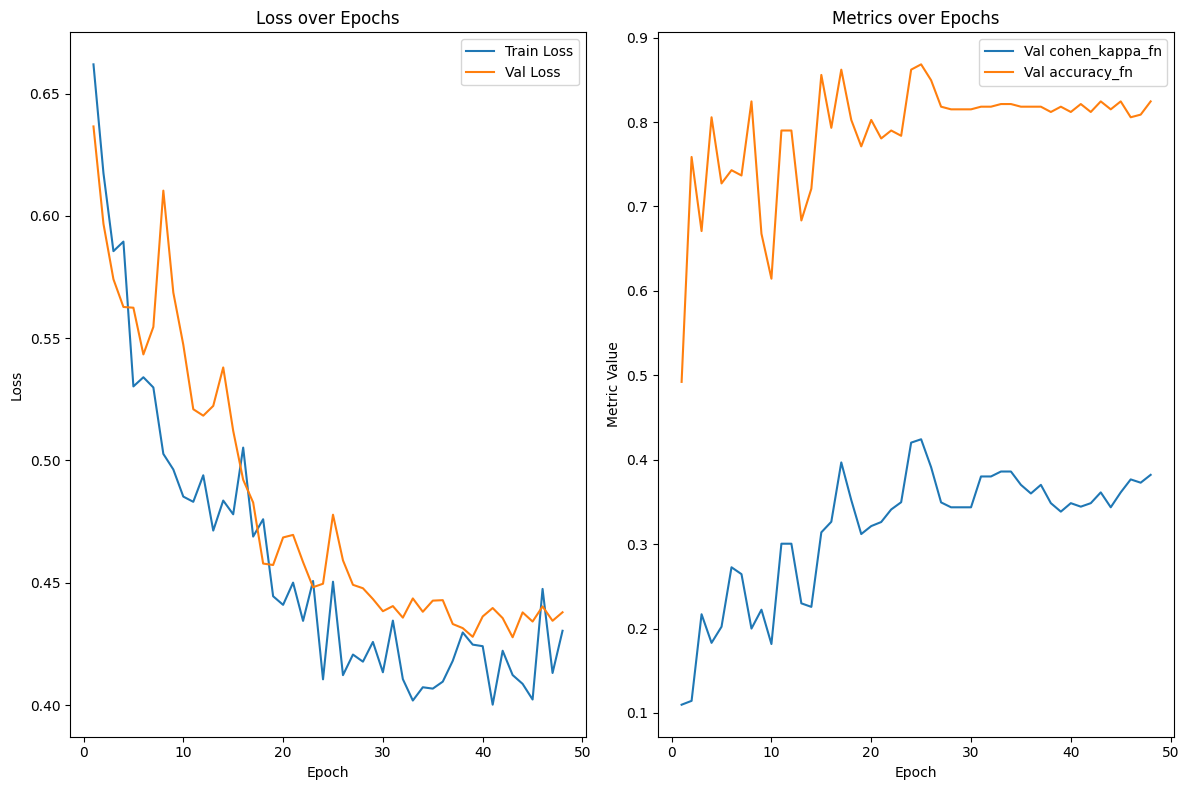

In [12]:
trainer_cnn_0.plot_epochs()

In [13]:
test_loss, test_metrics = trainer_cnn_0.evaluate(test_loader)
metrics_str = " | ".join(
    f"Test {name}: {value:.4f}"
    for name, value in zip(trainer_cnn_0.metric_names, test_metrics)
)
print(f"Test Loss: {test_loss:.4f} | {metrics_str}")

Test Loss: 0.4561 | Test cohen_kappa_fn: 0.4898 | Test accuracy_fn: 0.8396


### 3.3. CNN1

In [14]:
cnn_1 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[32,16,8],
    conv_channels=[8,16,32],
    use_dropout=True,
    use_batchnorm=True,
)
summary(cnn_1, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]             216
       BatchNorm2d-2          [-1, 8, 224, 224]              16
              ReLU-3          [-1, 8, 224, 224]               0
         MaxPool2d-4          [-1, 8, 112, 112]               0
            Conv2d-5         [-1, 16, 112, 112]           1,152
       BatchNorm2d-6         [-1, 16, 112, 112]              32
              ReLU-7         [-1, 16, 112, 112]               0
         MaxPool2d-8           [-1, 16, 56, 56]               0
            Conv2d-9           [-1, 32, 56, 56]           4,608
      BatchNorm2d-10           [-1, 32, 56, 56]              64
             ReLU-11           [-1, 32, 56, 56]               0
        MaxPool2d-12           [-1, 32, 28, 28]               0
           Linear-13                   [-1, 32]         802,848
             ReLU-14                   

In [15]:
optimizer_cnn_1 = optim.Adam(cnn_1.parameters(), lr=1e-4)
scheduler_cnn_1 = optim.lr_scheduler.StepLR(optimizer_cnn_1, step_size=25, gamma=0.1)
ckpt_cnn_1 = "weights/cnn_1.pt"
trainer_cnn_1 = Trainer(
    model=cnn_1,
    optimizer=optimizer_cnn_1,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_1,
    checkpoint_path=ckpt_cnn_1,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn],
)

In [16]:
trainer_cnn_1.fit(train_loader, valid_loader, num_epochs=100)

📘 Epoch 1 | Train Loss: 0.6932 | Val Loss: 0.6931 | Val cohen_kappa_fn: 0.0378 | Val accuracy_fn: 0.2445
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6931 | Val Loss: 0.6931 | Val cohen_kappa_fn: 0.1465 | Val accuracy_fn: 0.5486
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.6929 | Val Loss: 0.6928 | Val cohen_kappa_fn: 0.1162 | Val accuracy_fn: 0.4326
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.6924 | Val Loss: 0.6920 | Val cohen_kappa_fn: 0.2215 | Val accuracy_fn: 0.6332
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.6905 | Val Loss: 0.6892 | Val cohen_kappa_fn: 0.2325 | Val accuracy_fn: 0.6614
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.6870 | Val Loss: 0.6831 | Val cohen_kappa_fn: 0.1800 | Val accuracy_fn: 0.5361
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.6774 | Val Loss: 0.6686 | Val cohen_kappa_fn: 0.2265 | Val accuracy_fn: 0.6803
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.6574 | Val Loss: 0.6467 | Val cohen_kappa_fn: 0.2045 | Val accuracy_fn: 0.6050
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.6315 | Val Loss: 0.6092 | Val cohen_kappa_fn: 0.2207 | Val accuracy_fn: 0.6238
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.5884 | Val Loss: 0.5782 | Val cohen_kappa_fn: 0.2905 | Val accuracy_fn: 0.7837
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.5783 | Val Loss: 0.5686 | Val cohen_kappa_fn: 0.2621 | Val accuracy_fn: 0.8245
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.5652 | Val Loss: 0.5382 | Val cohen_kappa_fn: 0.3504 | Val accuracy_fn: 0.7900
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.5406 | Val Loss: 0.5399 | Val cohen_kappa_fn: 0.3461 | Val accuracy_fn: 0.7931
  ❄️ Performance droped, model won't be saved!


📘 Epoch 14 | Train Loss: 0.5094 | Val Loss: 0.5512 | Val cohen_kappa_fn: 0.2778 | Val accuracy_fn: 0.8182
  ❄️ Performance droped, model won't be saved!


📘 Epoch 15 | Train Loss: 0.5114 | Val Loss: 0.5035 | Val cohen_kappa_fn: 0.3255 | Val accuracy_fn: 0.7492
  🔥 New best model saved!


📘 Epoch 16 | Train Loss: 0.5052 | Val Loss: 0.5228 | Val cohen_kappa_fn: 0.3331 | Val accuracy_fn: 0.8213
  ❄️ Performance droped, model won't be saved!


📘 Epoch 17 | Train Loss: 0.4849 | Val Loss: 0.4887 | Val cohen_kappa_fn: 0.3735 | Val accuracy_fn: 0.7931
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.4848 | Val Loss: 0.5143 | Val cohen_kappa_fn: 0.3841 | Val accuracy_fn: 0.8307
  ❄️ Performance droped, model won't be saved!


📘 Epoch 19 | Train Loss: 0.4640 | Val Loss: 0.4683 | Val cohen_kappa_fn: 0.3296 | Val accuracy_fn: 0.7461
  🔥 New best model saved!


📘 Epoch 20 | Train Loss: 0.4541 | Val Loss: 0.4674 | Val cohen_kappa_fn: 0.4326 | Val accuracy_fn: 0.8401
  🔥 New best model saved!


📘 Epoch 21 | Train Loss: 0.4452 | Val Loss: 0.4512 | Val cohen_kappa_fn: 0.3822 | Val accuracy_fn: 0.7774
  🔥 New best model saved!


📘 Epoch 22 | Train Loss: 0.4272 | Val Loss: 0.4359 | Val cohen_kappa_fn: 0.3332 | Val accuracy_fn: 0.7367
  🔥 New best model saved!


📘 Epoch 23 | Train Loss: 0.4249 | Val Loss: 0.4292 | Val cohen_kappa_fn: 0.4091 | Val accuracy_fn: 0.7994
  🔥 New best model saved!


📘 Epoch 24 | Train Loss: 0.3904 | Val Loss: 0.4338 | Val cohen_kappa_fn: 0.3540 | Val accuracy_fn: 0.7524
  ❄️ Performance droped, model won't be saved!


📘 Epoch 25 | Train Loss: 0.4083 | Val Loss: 0.4177 | Val cohen_kappa_fn: 0.4994 | Val accuracy_fn: 0.8589
  🔥 New best model saved!


📘 Epoch 26 | Train Loss: 0.4212 | Val Loss: 0.4109 | Val cohen_kappa_fn: 0.4897 | Val accuracy_fn: 0.8433
  🔥 New best model saved!


📘 Epoch 27 | Train Loss: 0.3886 | Val Loss: 0.4096 | Val cohen_kappa_fn: 0.4710 | Val accuracy_fn: 0.8339
  🔥 New best model saved!


📘 Epoch 28 | Train Loss: 0.4068 | Val Loss: 0.4087 | Val cohen_kappa_fn: 0.4474 | Val accuracy_fn: 0.8213
  🔥 New best model saved!


📘 Epoch 29 | Train Loss: 0.4104 | Val Loss: 0.4056 | Val cohen_kappa_fn: 0.4534 | Val accuracy_fn: 0.8119
  🔥 New best model saved!


📘 Epoch 30 | Train Loss: 0.3790 | Val Loss: 0.4113 | Val cohen_kappa_fn: 0.4668 | Val accuracy_fn: 0.8276
  ❄️ Performance droped, model won't be saved!


📘 Epoch 31 | Train Loss: 0.3921 | Val Loss: 0.4076 | Val cohen_kappa_fn: 0.4710 | Val accuracy_fn: 0.8339
  ❄️ Performance droped, model won't be saved!


📘 Epoch 32 | Train Loss: 0.4125 | Val Loss: 0.4095 | Val cohen_kappa_fn: 0.4532 | Val accuracy_fn: 0.8245
  ❄️ Performance droped, model won't be saved!


📘 Epoch 33 | Train Loss: 0.3747 | Val Loss: 0.4062 | Val cohen_kappa_fn: 0.4834 | Val accuracy_fn: 0.8401
  ❄️ Performance droped, model won't be saved!


📘 Epoch 34 | Train Loss: 0.3793 | Val Loss: 0.4078 | Val cohen_kappa_fn: 0.4710 | Val accuracy_fn: 0.8339
  ❄️ Performance droped, model won't be saved!
⏹️ Early stopping triggered.


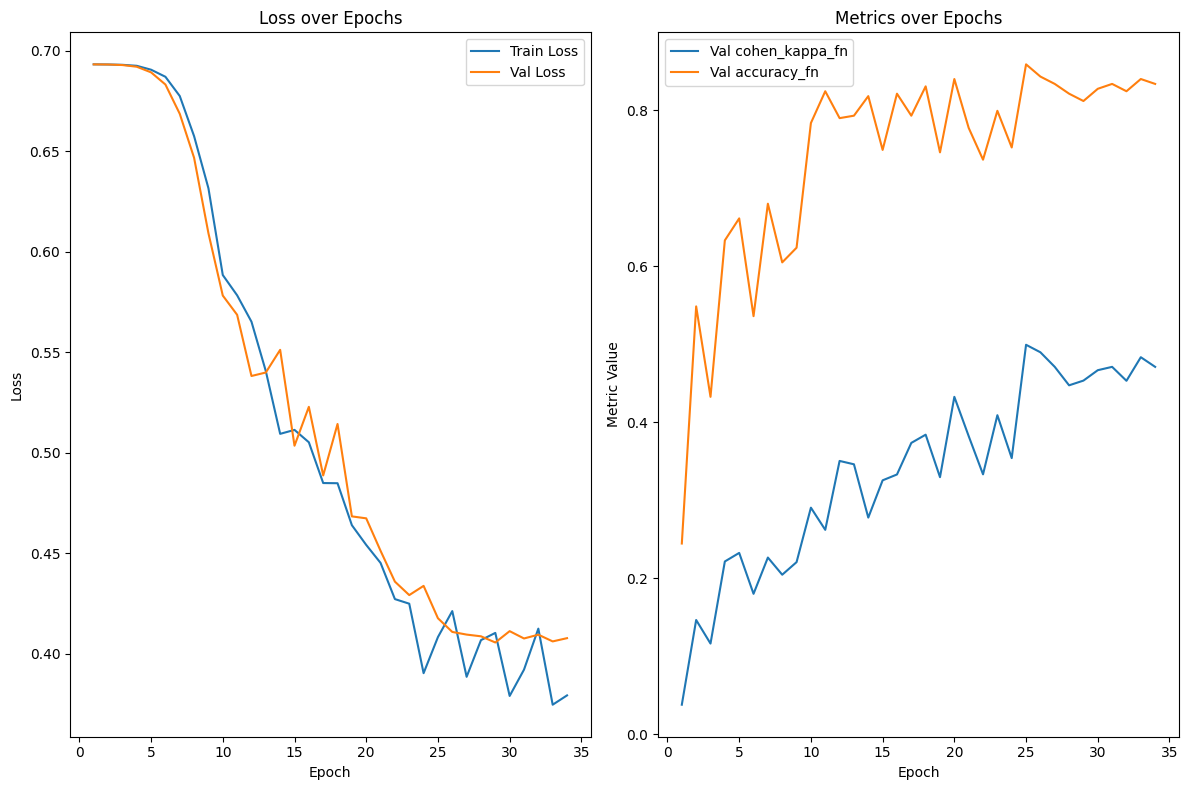

In [17]:
trainer_cnn_1.plot_epochs()

In [18]:
test_loss, test_metrics = trainer_cnn_1.evaluate(test_loader)
metrics_str = " | ".join(
    f"Test {name}: {value:.4f}"
    for name, value in zip(trainer_cnn_1.metric_names, test_metrics)
)
print(f"Test Loss: {test_loss:.4f} | {metrics_str}")

Test Loss: 0.4396 | Test cohen_kappa_fn: 0.4824 | Test accuracy_fn: 0.8313


### 3.4. CNN2

In [19]:
cnn_2 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[256],
    conv_channels=[32,64,128],
    use_dropout=True,
    use_batchnorm=True,
)
summary(cnn_2, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             864
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
         MaxPool2d-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]          18,432
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
         MaxPool2d-8           [-1, 64, 56, 56]               0
            Conv2d-9          [-1, 128, 56, 56]          73,728
      BatchNorm2d-10          [-1, 128, 56, 56]             256
             ReLU-11          [-1, 128, 56, 56]               0
        MaxPool2d-12          [-1, 128, 28, 28]               0
           Linear-13                  [-1, 256]      25,690,368
             ReLU-14                  [

In [20]:
optimizer_cnn_2 = optim.Adam(cnn_2.parameters(), lr=1e-4)
scheduler_cnn_2 = optim.lr_scheduler.StepLR(optimizer_cnn_2, step_size=25, gamma=0.1)
ckpt_cnn_2 = "weights/cnn_2.pt"
trainer_cnn_2 = Trainer(
    model=cnn_2,
    optimizer=optimizer_cnn_2,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_2,
    checkpoint_path=ckpt_cnn_2,
    patience=5,
    metric_fns=[cohen_kappa_fn, accuracy_fn],
)

In [21]:
trainer_cnn_2.fit(train_loader, valid_loader, num_epochs=100)

📘 Epoch 1 | Train Loss: 0.8462 | Val Loss: 0.6171 | Val cohen_kappa_fn: 0.1328 | Val accuracy_fn: 0.6395
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6124 | Val Loss: 0.5865 | Val cohen_kappa_fn: 0.1629 | Val accuracy_fn: 0.5611
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.5411 | Val Loss: 0.5385 | Val cohen_kappa_fn: 0.2488 | Val accuracy_fn: 0.7241
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.5068 | Val Loss: 0.5410 | Val cohen_kappa_fn: 0.2648 | Val accuracy_fn: 0.7962
  ❄️ Performance droped, model won't be saved!


📘 Epoch 5 | Train Loss: 0.4858 | Val Loss: 0.4535 | Val cohen_kappa_fn: 0.3176 | Val accuracy_fn: 0.7116
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.4348 | Val Loss: 0.4525 | Val cohen_kappa_fn: 0.3491 | Val accuracy_fn: 0.7429
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.3738 | Val Loss: 0.4130 | Val cohen_kappa_fn: 0.4716 | Val accuracy_fn: 0.8182
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.4022 | Val Loss: 0.4173 | Val cohen_kappa_fn: 0.5531 | Val accuracy_fn: 0.9154
  ❄️ Performance droped, model won't be saved!


📘 Epoch 9 | Train Loss: 0.3730 | Val Loss: 0.3282 | Val cohen_kappa_fn: 0.6350 | Val accuracy_fn: 0.8997
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.3512 | Val Loss: 0.3291 | Val cohen_kappa_fn: 0.6710 | Val accuracy_fn: 0.9248
  ❄️ Performance droped, model won't be saved!


📘 Epoch 11 | Train Loss: 0.2751 | Val Loss: 0.3366 | Val cohen_kappa_fn: 0.4264 | Val accuracy_fn: 0.7774
  ❄️ Performance droped, model won't be saved!


📘 Epoch 12 | Train Loss: 0.3147 | Val Loss: 0.2770 | Val cohen_kappa_fn: 0.6410 | Val accuracy_fn: 0.8997
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.2515 | Val Loss: 0.3291 | Val cohen_kappa_fn: 0.6420 | Val accuracy_fn: 0.9248
  ❄️ Performance droped, model won't be saved!


📘 Epoch 14 | Train Loss: 0.2754 | Val Loss: 0.4828 | Val cohen_kappa_fn: 0.2534 | Val accuracy_fn: 0.6207
  ❄️ Performance droped, model won't be saved!


📘 Epoch 15 | Train Loss: 0.2311 | Val Loss: 0.2368 | Val cohen_kappa_fn: 0.7101 | Val accuracy_fn: 0.9310
  🔥 New best model saved!


📘 Epoch 16 | Train Loss: 0.2125 | Val Loss: 0.2824 | Val cohen_kappa_fn: 0.7312 | Val accuracy_fn: 0.9373
  ❄️ Performance droped, model won't be saved!


📘 Epoch 17 | Train Loss: 0.2243 | Val Loss: 0.3391 | Val cohen_kappa_fn: 0.4217 | Val accuracy_fn: 0.7743
  ❄️ Performance droped, model won't be saved!


📘 Epoch 18 | Train Loss: 0.2173 | Val Loss: 0.2876 | Val cohen_kappa_fn: 0.6679 | Val accuracy_fn: 0.9279
  ❄️ Performance droped, model won't be saved!


📘 Epoch 19 | Train Loss: 0.2346 | Val Loss: 0.2921 | Val cohen_kappa_fn: 0.5081 | Val accuracy_fn: 0.8307
  ❄️ Performance droped, model won't be saved!


📘 Epoch 20 | Train Loss: 0.2005 | Val Loss: 0.2369 | Val cohen_kappa_fn: 0.6308 | Val accuracy_fn: 0.8934
  ❄️ Performance droped, model won't be saved!
⏹️ Early stopping triggered.


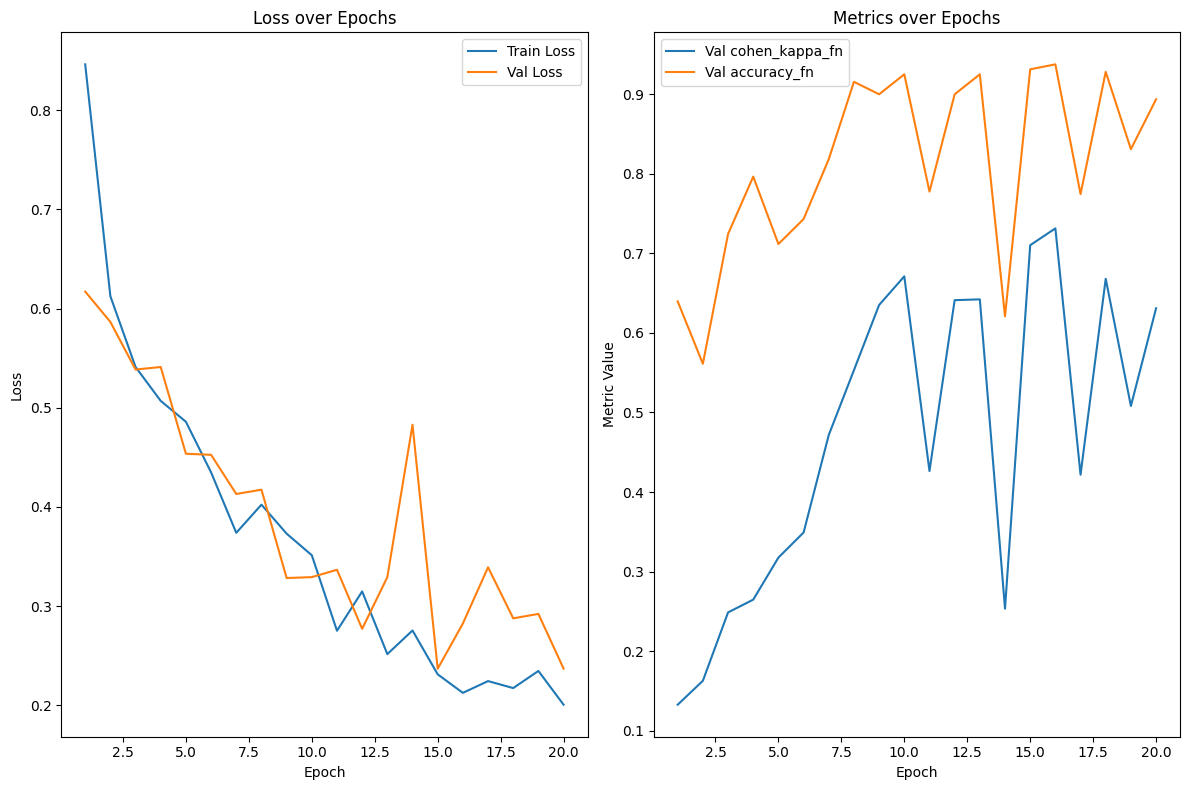

In [22]:
trainer_cnn_2.plot_epochs()

In [23]:
test_loss, test_metrics = trainer_cnn_2.evaluate(test_loader)
metrics_str = " | ".join(
    f"Test {name}: {value:.4f}"
    for name, value in zip(trainer_cnn_2.metric_names, test_metrics)
)
print(f"Test Loss: {test_loss:.4f} | {metrics_str}")

Test Loss: 0.2569 | Test cohen_kappa_fn: 0.6343 | Test accuracy_fn: 0.8792
